In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. WHP & Sociodemographic Mapping')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. WHP & Sociodemographic Mapping/Output')
cur_date = "062223"

library(readxl)
library(tidyverse)
library(reshape2)
library(tigris)
library(cowplot)
library(rcartocolor)
library(tidytext)
library(gridExtra)

# reading in files
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))
ej_screen_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Sociodemographic_Clusters_030123.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
head(ej_screen_geo_id_clusters)

,GEO_ID,Census_Tract,County,Variables,Value,Scaled_Value,Cluster
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201,Alamance,Population_Under_5,9.5,1.45508797,3
2,14000US37001020100,201,Alamance,Population_Over_65,15.1,-0.20849618,3
3,14000US37001020100,201,Alamance,Race_Non_White,39.0,0.33121718,3
4,14000US37001020100,201,Alamance,Hispanic_Latino,9.5,0.04837140,3
5,14000US37001020100,201,Alamance,Non_Proficient_English_Speakers,3.9,-0.09907552,3
6,14000US37001020100,201,Alamance,Poverty_Overall,27.2,1.07521173,3


In [3]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)

  |======================================================================| 100%


In [4]:
# just using the whp file since it contains the FIPS col necessary to join w/ the shapefile
whp_df$FIPS = as.character(whp_df$FIPS)
nc_census_tract_shapefile = full_join(whp_df[,1:4], nc_census_tract_shapefile)
   
# creating 1 df
variables_of_interest = c("Population_Over_65", "Race_Non_White", "Poverty_Overall", "Less_than_High_School")
ej_screen_df = full_join(nc_census_tract_shapefile, ej_screen_geo_id_clusters[,1:6]) %>%
    # getting variables of interest
    filter(Variables %in% variables_of_interest)

# for some reason had to add these with missing values back in 
`%notin%` <- Negate(`%in%`)
missing_tracts_df = nc_census_tract_shapefile %>%
    filter(FIPS %notin% unique(ej_screen_df$FIPS))

missing_tracts_df$Population_Over_65 = NA
missing_tracts_df$Race_Non_White = NA
missing_tracts_df$Poverty_Overall = NA
missing_tracts_df$Less_than_High_School = NA

missing_tracts_df = missing_tracts_df %>%
    pivot_longer(cols = 19:22, names_to = "Variables", values_to = "Value") %>%
    mutate(Scaled_Value = NA)

ej_screen_df = rbind(ej_screen_df, missing_tracts_df) 

head(ej_screen_df)

Joining with `by = join_by(FIPS)`
Joining with `by = join_by(GEO_ID, County, Census_Tract)`


,GEO_ID,FIPS,County,Census_Tract,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,⋯,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Variables,Value,Scaled_Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>,<dbl>,<dbl>
1,14000US37141920201,37141920201,Pender,9202.01,37,141,920201,9202.01,Census Tract 9202.01,G5020,⋯,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Population_Over_65,18.3,0.2137770
2,14000US37141920201,37141920201,Pender,9202.01,37,141,920201,9202.01,Census Tract 9202.01,G5020,⋯,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Race_Non_White,7.9,-0.9882899
3,14000US37141920201,37141920201,Pender,9202.01,37,141,920201,9202.01,Census Tract 9202.01,G5020,⋯,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Poverty_Overall,4.5,-1.0665186
4,14000US37141920201,37141920201,Pender,9202.01,37,141,920201,9202.01,Census Tract 9202.01,G5020,⋯,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Less_than_High_School,12.8,-0.7708501
5,14000US37141920401,37141920401,Pender,9204.01,37,141,920401,9204.01,Census Tract 9204.01,G5020,⋯,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,Population_Over_65,15.1,-0.2084962
6,14000US37141920401,37141920401,Pender,9204.01,37,141,920401,9204.01,Census Tract 9204.01,G5020,⋯,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,Race_Non_White,52.6,0.9082363


In [5]:
options(repr.plot.width = 15, repr.plot.height = 7) #changing size

# getting color palette
palette_colors = rev(carto_pal(5, "BluYl"))

over_65_map = ggplot() +
  geom_sf(data = ej_screen_df %>%
              filter(Variables == "Population_Over_65"), aes(fill = Value, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 
  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      strip.background = element_rect(color = "black"),
      strip.text = element_text(size = 15, face = "bold"), # changes size of facet x axis
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
                       name = "Population Over 65 (%)")
          
race_map = ggplot() +
  geom_sf(data = ej_screen_df %>%
              filter(Variables == "Race_Non_White"), aes(fill = Value, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 
  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      strip.background = element_rect(color = "black"),
      strip.text = element_text(size = 15, face = "bold"), # changes size of facet x axis
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
                       name = "Race Non-White (%)")

poverty_map = ggplot() +
  geom_sf(data = ej_screen_df %>%
              filter(Variables == "Poverty_Overall"), aes(fill = Value, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 
  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      strip.background = element_rect(color = "black"),
      strip.text = element_text(size = 15, face = "bold"), # changes size of facet x axis
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
                       name = "Below the Federal\nPoverty Level (%)")

education_map = ggplot() +
  geom_sf(data = ej_screen_df %>%
              filter(Variables == "Less_than_High_School"), aes(fill = Value, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 
  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      strip.background = element_rect(color = "black"),
      strip.text = element_text(size = 15, face = "bold"), # changes size of facet x axis
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
                       name = "     Less than High\nSchool Education (%) ")

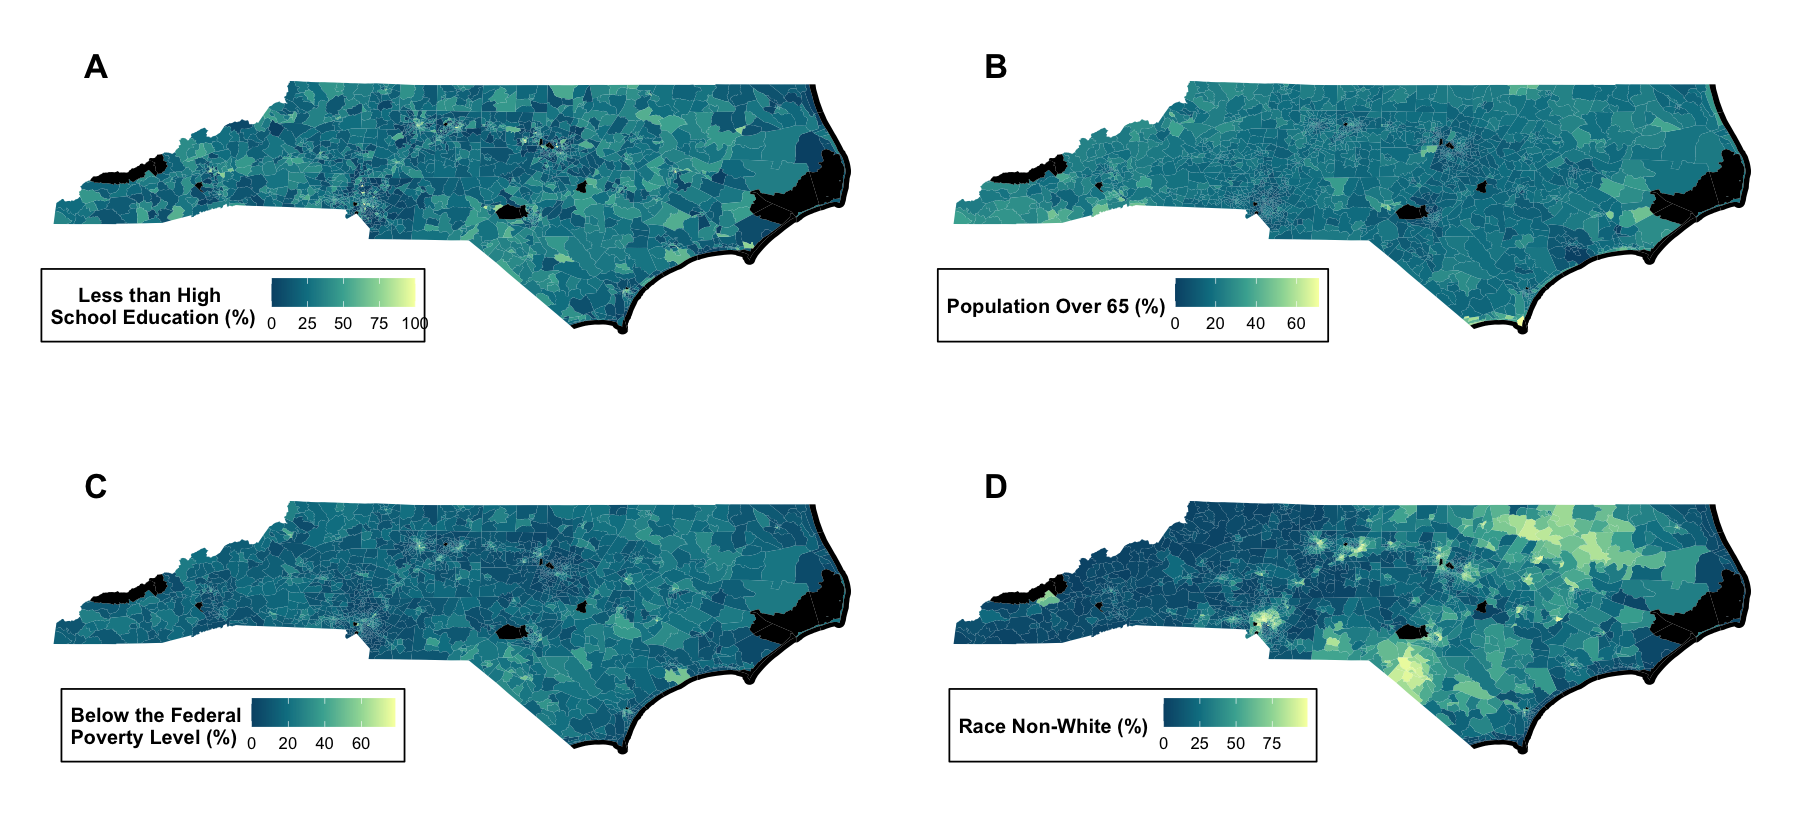

In [6]:
FigureX = plot_grid(education_map, over_65_map, poverty_map, race_map,
                   # adding labels, changing size their size and position
                    labels = "AUTO", label_size = 20, label_x = 0.08, label_y = 0.9)
FigureX